# Quantum Circuit Routing Demo
This notebook demonstrates quantum circuit routing using PyZX with different architectures.

In [14]:
import pyzx as zx
from fractions import Fraction
from pyzx.routing import (
    create_architecture, route_phase_poly, RoutingMethod, ElimMode
)
import matplotlib.pyplot as plt
import networkx as nx

## Create a Simple Quantum Circuit

This section creates a logical quantum circuit on 5 qubits with multiple CNOT gates and a mix of Clifford and non-Clifford ZPhase gates. The gate layout includes long-range interactions that are not natively supported by common hardware architectures, setting up a scenario where routing will need to insert additional operations.


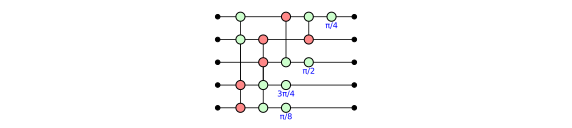

In [15]:
circ = zx.Circuit(5)

# Add logical interactions that are non-local in line or IBM QX4
circ.add_gate("CNOT", 0, 4)
circ.add_gate("CNOT", 1, 3)
circ.add_gate("CNOT", 4, 2)
circ.add_gate("CNOT", 2, 0)
circ.add_gate("CNOT", 3, 1)
circ.add_gate("CNOT", 0, 1)

# Add a mix of Clifford and T gates
circ.add_gate("ZPhase", 0, Fraction(1, 4))  # T gate
circ.add_gate("ZPhase", 2, Fraction(1, 2))  # Clifford
circ.add_gate("ZPhase", 3, Fraction(3, 4))  # non-Clifford
circ.add_gate("ZPhase", 4, Fraction(1, 8))  # non-Clifford

# Visualize original
zx.draw_matplotlib(circ, figsize=(10, 2), h_edge_draw='box')

## Define and Visualise Architectures

We visualise the logical (unrouted) quantum circuit using PyZX's drawing tools. This gives us a reference for how the circuit looks before being adapted to specific hardware constraints.


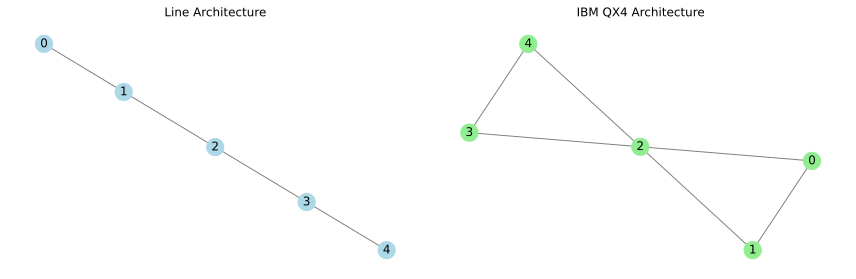

In [16]:
# Convert PyZX GraphS objects to NetworkX graphs
def pyzx_to_nx(pyzx_graph):
    g_nx = nx.Graph()
    for v in pyzx_graph.vertices():
        g_nx.add_node(v)
    for edge in pyzx_graph.edges():
        g_nx.add_edge(edge[0], edge[1])
    return g_nx

# Create predefined architectures using PyZX
line_arch = create_architecture('line', n_qubits=5)
ibm_arch = create_architecture('ibm_qx4') 

# Visualize Architectures
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
nx.draw(pyzx_to_nx(line_arch.graph), with_labels=True, node_color='lightblue', edge_color='gray')
plt.title('Line Architecture')

plt.subplot(1, 2, 2)
nx.draw(pyzx_to_nx(ibm_arch.graph), with_labels=True, node_color='lightgreen', edge_color='gray')
plt.title('IBM QX4 Architecture')

plt.tight_layout()
plt.show()


## Route the Circuit

We define two quantum hardware architectures:
- **Line Architecture**: A simple chain of qubits where only neighbors interact.
- **IBM QX4**: A realistic 5-qubit architecture with limited connectivity.
We visualise both to understand the connectivity limitations that will influence routing.

In [17]:
routed_circ_gray = route_phase_poly(circ, line_arch, method=RoutingMethod.GRAY, mode=ElimMode.STEINER_MODE)
print('Routed Circuit (Gray):', routed_circ_gray.gates)

routed_circ_combined = route_phase_poly(circ, ibm_arch, method=RoutingMethod.GRAY_MEIJER, mode=ElimMode.STEINER_MODE)
print('Routed Circuit (Combined):', routed_circ_combined.gates)

Routed Circuit (Gray): [CNOT(2,3), CNOT(3,2), CNOT(2,1), ZPhase(1,phase=3/4), CNOT(1,2), CNOT(4,3), CNOT(3,2), CNOT(2,1), CNOT(1,0), ZPhase(0,phase=1/2), CNOT(3,4), CNOT(2,3), CNOT(4,3), CNOT(3,2), CNOT(2,1), CNOT(1,0), ZPhase(0,phase=1/8), CNOT(2,1), ZPhase(1,phase=1/4), CNOT(3,2), CNOT(2,1), CNOT(1,0), CNOT(2,1), CNOT(3,2), CNOT(4,3), CNOT(3,2), CNOT(2,1), CNOT(1,0), CNOT(2,1), CNOT(3,2), CNOT(3,4), CNOT(4,3), CNOT(2,3), CNOT(3,2), CNOT(1,2), CNOT(2,3), CNOT(3,4), CNOT(3,2), CNOT(4,3), CNOT(0,1), CNOT(1,2), CNOT(2,3), CNOT(3,4), CNOT(1,0), CNOT(2,1), CNOT(4,3)]
Routed Circuit (Combined): [CNOT(4,2), ZPhase(2,phase=1/4), CNOT(0,2), ZPhase(2,phase=1/2), CNOT(2,4), CNOT(4,2), CNOT(0,2), ZPhase(2,phase=1/8), CNOT(0,1), CNOT(1,0), CNOT(2,0), CNOT(0,2), CNOT(2,3), ZPhase(3,phase=3/4), CNOT(2,0), CNOT(2,1), CNOT(3,2), CNOT(2,0), CNOT(2,1), CNOT(4,2), CNOT(2,0), CNOT(4,2), CNOT(1,2), CNOT(2,4), CNOT(2,1), CNOT(0,2), CNOT(2,4), CNOT(0,1)]


## Visualise Original and Routed Circuits

We apply PyZX’s routing algorithms to map the logical circuit onto each architecture:
- **Gray (Line)**: Routes the circuit to a linear qubit layout.
- **Gray+Meijer (IBM QX4)**: Routes using additional heuristics for the more restrictive IBM QX4 layout.

Routing inserts extra gates to satisfy hardware connectivity constraints.


Original Circuit:


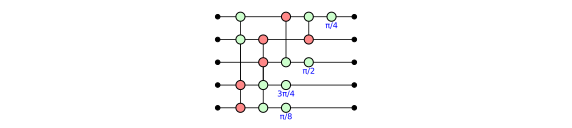

In [18]:
# Visualize Results
print("\nOriginal Circuit:")
zx.draw_matplotlib(circ, figsize=(10, 2), h_edge_draw='box')


Routed Circuit (Gray) on Line:


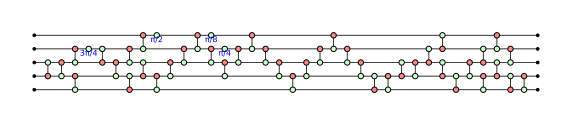

In [19]:
print("\nRouted Circuit (Gray) on Line:")
zx.draw_matplotlib(routed_circ_gray, figsize=(10, 2), h_edge_draw='box')


Routed Circuit (Combined) on IBM QX4:


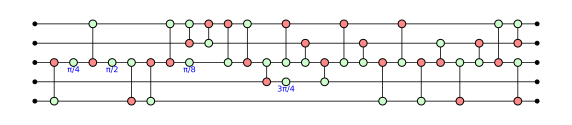

In [20]:
print("\nRouted Circuit (Combined) on IBM QX4:")
zx.draw_matplotlib(routed_circ_combined, figsize=(10, 2), h_edge_draw='box')

## Benchmark Circuit Statistics

This section outputs a summary of gate counts, CNOT counts, and T-counts for each version of the circuit. It highlights the trade-offs in complexity introduced by routing.


In [21]:
print('Original Circuit Stats:', circ.stats())
print('Routed Circuit (Gray) Stats:', routed_circ_gray.stats())
print('Routed Circuit (Combined) Stats:', routed_circ_combined.stats())

Original Circuit Stats: Circuit  on 5 qubits with 10 gates.
        3 is the T-count
        7 Cliffords among which
        6 2-qubit gates (6 CNOT, 0 other) and
        0 Hadamard gates.
Routed Circuit (Gray) Stats: Circuit  on 5 qubits with 46 gates.
        3 is the T-count
        43 Cliffords among which
        42 2-qubit gates (42 CNOT, 0 other) and
        0 Hadamard gates.
Routed Circuit (Combined) Stats: Circuit  on 5 qubits with 28 gates.
        3 is the T-count
        25 Cliffords among which
        24 2-qubit gates (24 CNOT, 0 other) and
        0 Hadamard gates.
